In [1]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)

source("../../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

Loading required package: magrittr
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel

Attaching package: ‘data.table’

The following objects are masked from ‘package:reshape2’:

    dcast, melt

Loading required package: prodlim

 randomForestSRC 2.9.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 

Loading required package: RColorBrewer
Loading required package: lattice
Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:randomForestSRC’:

    impute

The following objects are masked from ‘package:base’:

    format.pval, units


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:Hmisc’:

    src, summarize

The following objects are masked from ‘package:data.table’:

    between, first, last

The followin

In [2]:
df_reshuffling_RFS <- NULL
df_reshuffling_OS_CR <- NULL
df_reshuffling_os <- NULL
for (l in list.files('Reshuffle')){
    if (grepl("_reshuffle_importance_RFS.tsv",l)){
        df_tmp <- read.table(paste('Reshuffle/',l,sep=""))
        df_tmp$Ratio <- df_tmp$ref_CI/df_tmp$permuted_CI
        df_tmp <- df_tmp[,c("feature","Ratio","algo","model")]
        df_reshuffling_RFS <- rbind(df_reshuffling_RFS,df_tmp)     
    }
    if (grepl("_reshuffle_importance_OS_CR.tsv",l)){
        df_tmp <- read.table(paste('Reshuffle/',l,sep=""))
        df_tmp$Ratio <- df_tmp$ref_CI/df_tmp$permuted_CI
        df_tmp <- df_tmp[,c("feature","Ratio","algo","model")]
        df_reshuffling_OS_CR <- rbind(df_reshuffling_OS_CR,df_tmp)     
    }
    if (grepl("_reshuffle_importance_os.tsv",l)){
        df_tmp <- read.table(paste('Reshuffle/',l,sep=""))
        df_tmp$Ratio <- df_tmp$ref_CI/df_tmp$permuted_CI
        df_tmp <- df_tmp[,c("feature","Ratio","algo","model")]
        df_reshuffling_os <- rbind(df_reshuffling_os,df_tmp)     
    }    
}





In [3]:
df_final <- read.table("../../../clustering/clustering_Final_1/df_final_full_component_ITD.tsv")
eln <- colnames(df_final[,c(2,3,4)])
comp <- colnames(df_final[,c(170:193)])

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
clin <- colnames(df_final[,c(159:165)])
demo <- colnames(df_final[,c(166:167)])
mrd <- c("CR_MRD_neg","CR_MRD_pos","all_others")
              
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",mrd="pink")  


In [4]:
# Function showing Feature Importance for the Models



importance <- function (data=df_reshuffling_os , models=unique(df_reshuffling_os$model),fun=mean,width=25,height=40,title=""){
    for (model in models){
#         set_notebook_plot_size(width,height)
        #Resuflling Importance
        df_reshuffling <- data
        feature_model <- df_reshuffling[df_reshuffling$model==model ,] 
        #%>% filter(str_detect(model, c("0.7|0|1|boost|rfs")))

        feature_model <- feature_model[,c('feature','Ratio','algo')] %>% group_by(feature,algo)  
        #%>% summarize_all(sum)

        feature_model$category <- ifelse(is.element(feature_model$feature,eln),"eln",
                                       ifelse(is.element(feature_model$feature,comp),"comp",
                                             ifelse(is.element(feature_model$feature,gen),"gen",
                                                   ifelse(is.element(feature_model$feature,cyto),"cyto",
                                                         ifelse(is.element(feature_model$feature,clin),"clin",
                                                             ifelse(is.element(feature_model$feature,mrd),"mrd","demo"))))))
        feature_model$feature <- str_replace(feature_model$feature,"full_component_","")

        feature_model$algo <- toupper(feature_model$algo)
        #feature_model$algo <- ifelse(feature_model$algo=="COX","SIMPLE_COX",feature_model$algo)

        # Bootstrapping + Coef Importance

        p <- ggplot(na.omit(feature_model),aes(x=reorder(feature,Ratio,FUN=fun),y=Ratio,fill=category))+geom_boxplot()+facet_wrap(~algo,ncol=6)+
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=13),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=13))+xlab("Selected Features") +
        ylab("Ratio (ref_CI/Permuted_CI) ") +coord_flip() +scale_fill_manual(values=pal,limits=names(pal)) + #ggtitle(paste(model, "Model Feature importance Reshuffling"))
        ggtitle(title)

        
        return(p)



    }
}

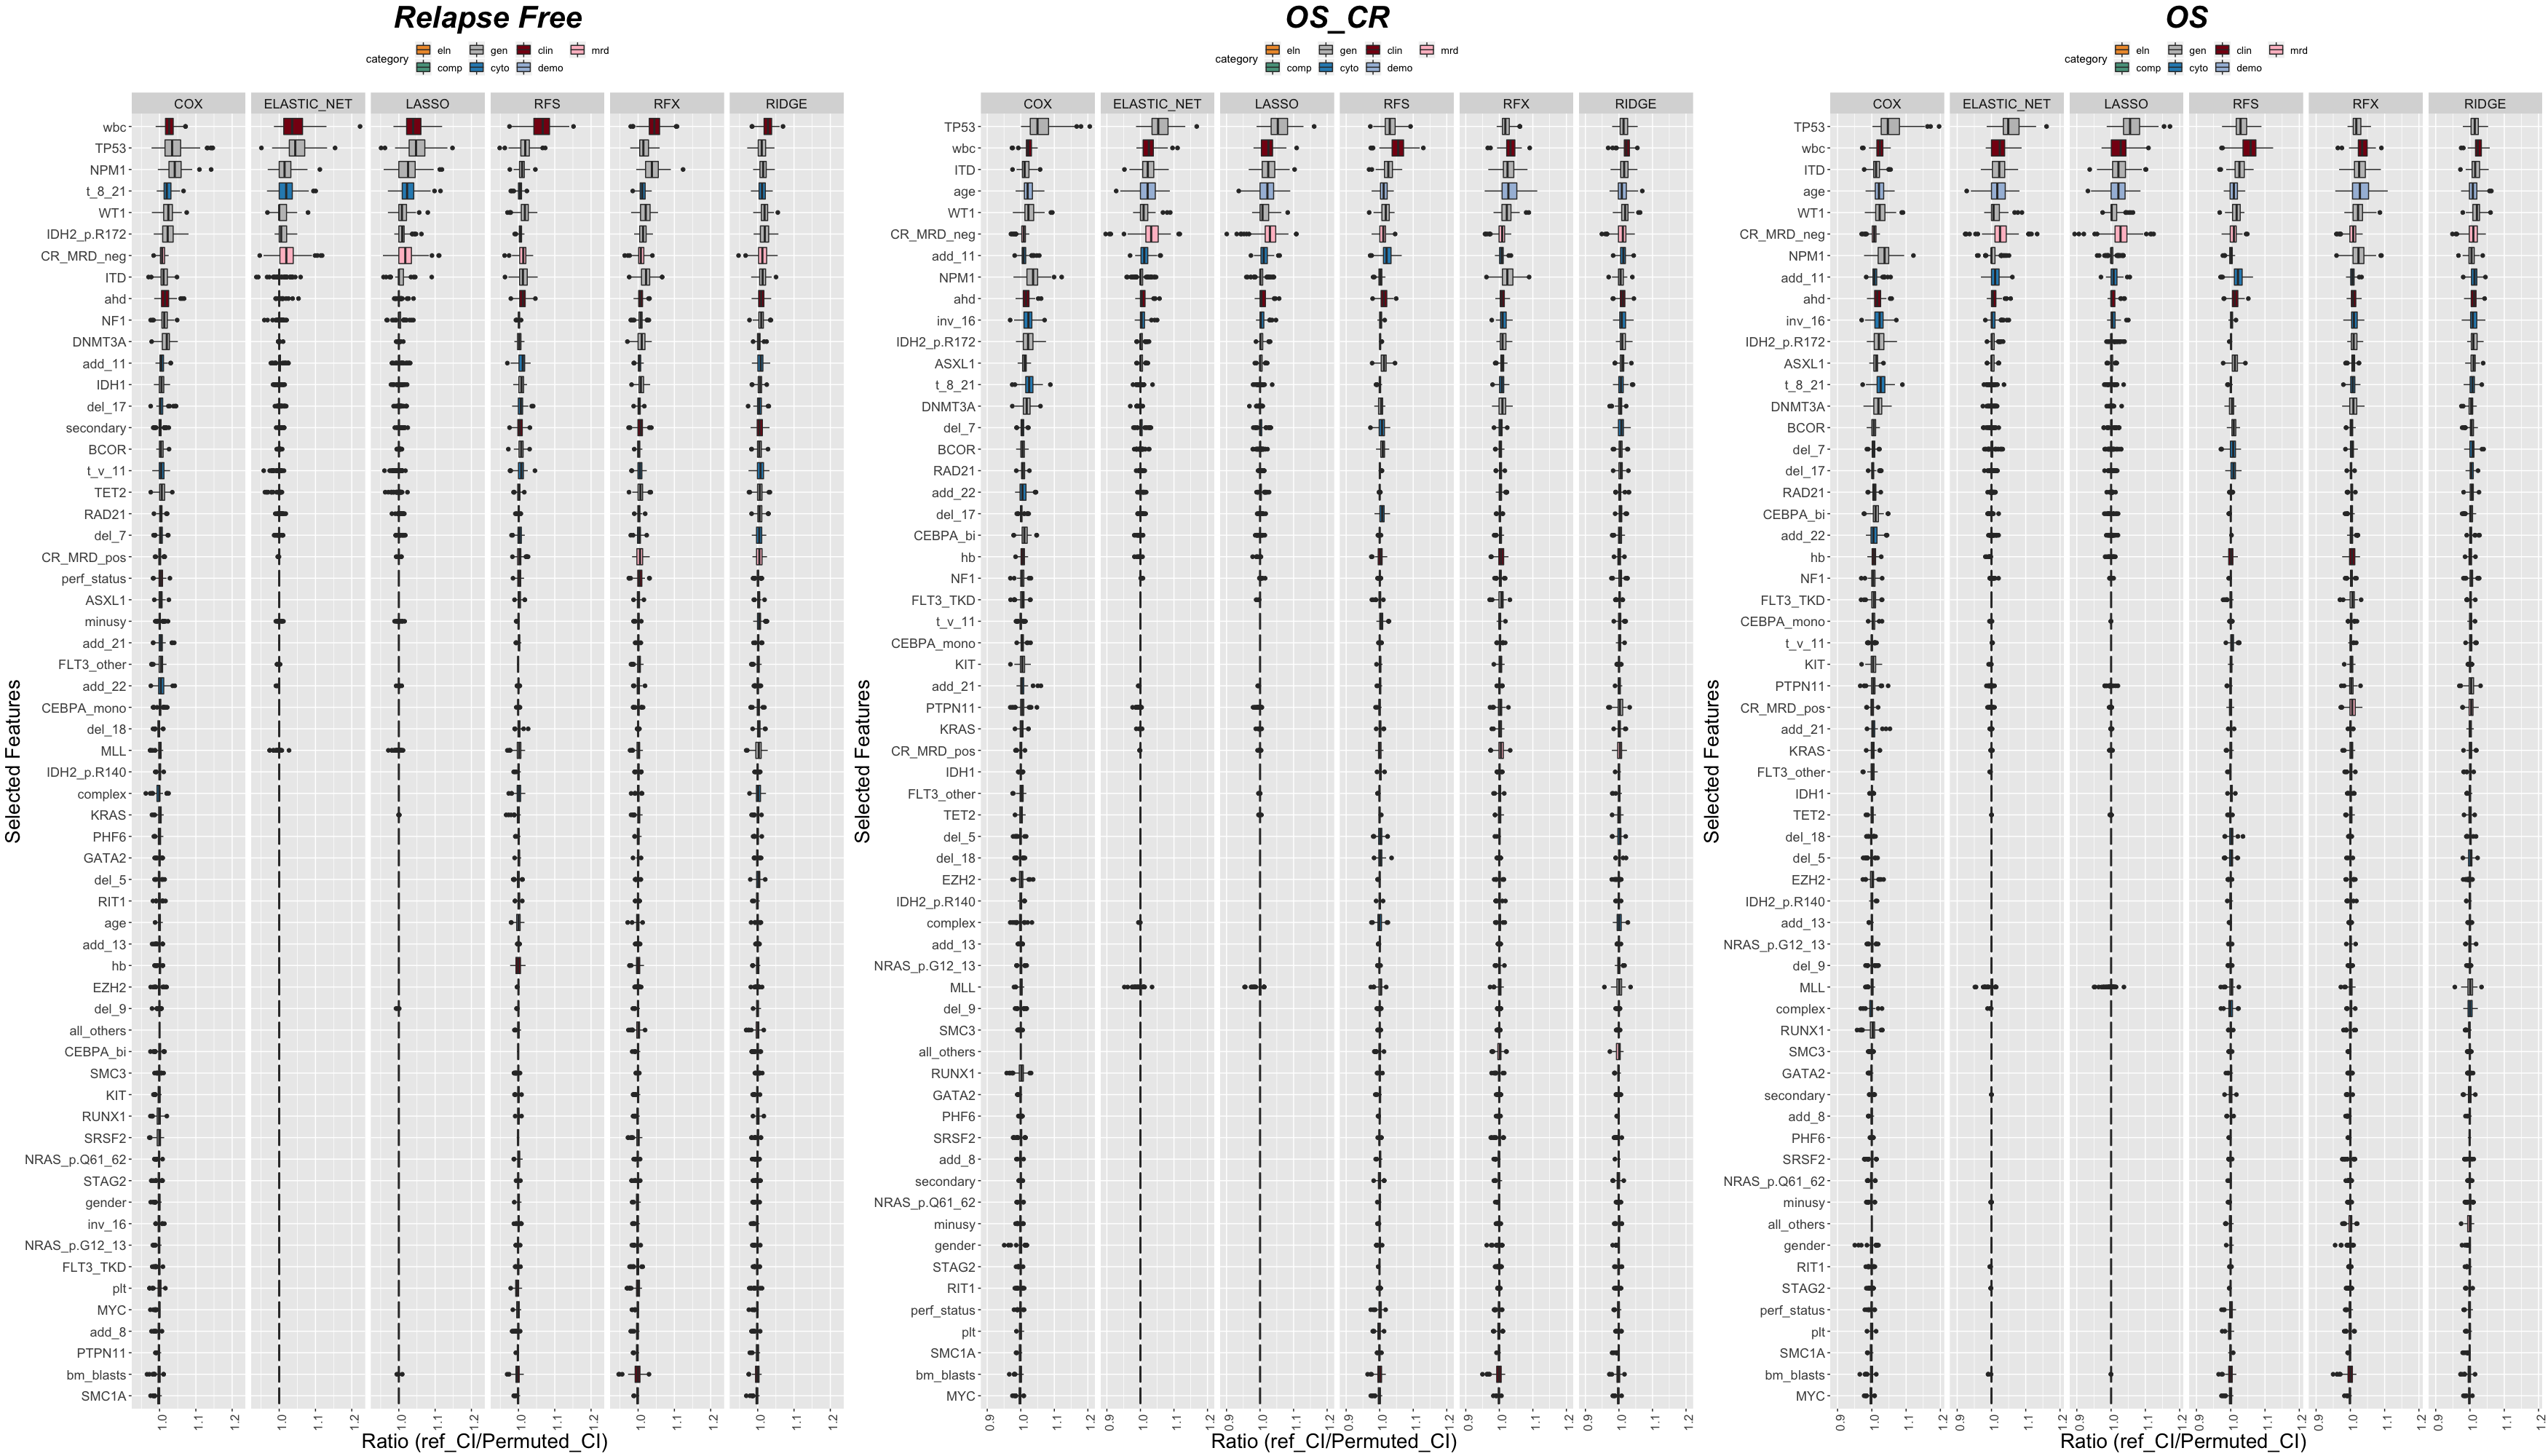

In [11]:
set_notebook_plot_size(35,20)
co <- c("gen_cyto_clin_demo")
grid.arrange(importance(data=df_reshuffling_RFS,models=paste(co,"_mrd",sep=""),title= "Relapse Free"),
             importance(data=df_reshuffling_OS_CR,models=paste(co,"_mrd",sep=""),title= "OS_CR"),
             importance(data=df_reshuffling_os,models=paste(co,"_mrd",sep=""),title= "OS"),nrow=1)


# Age effect on RFS

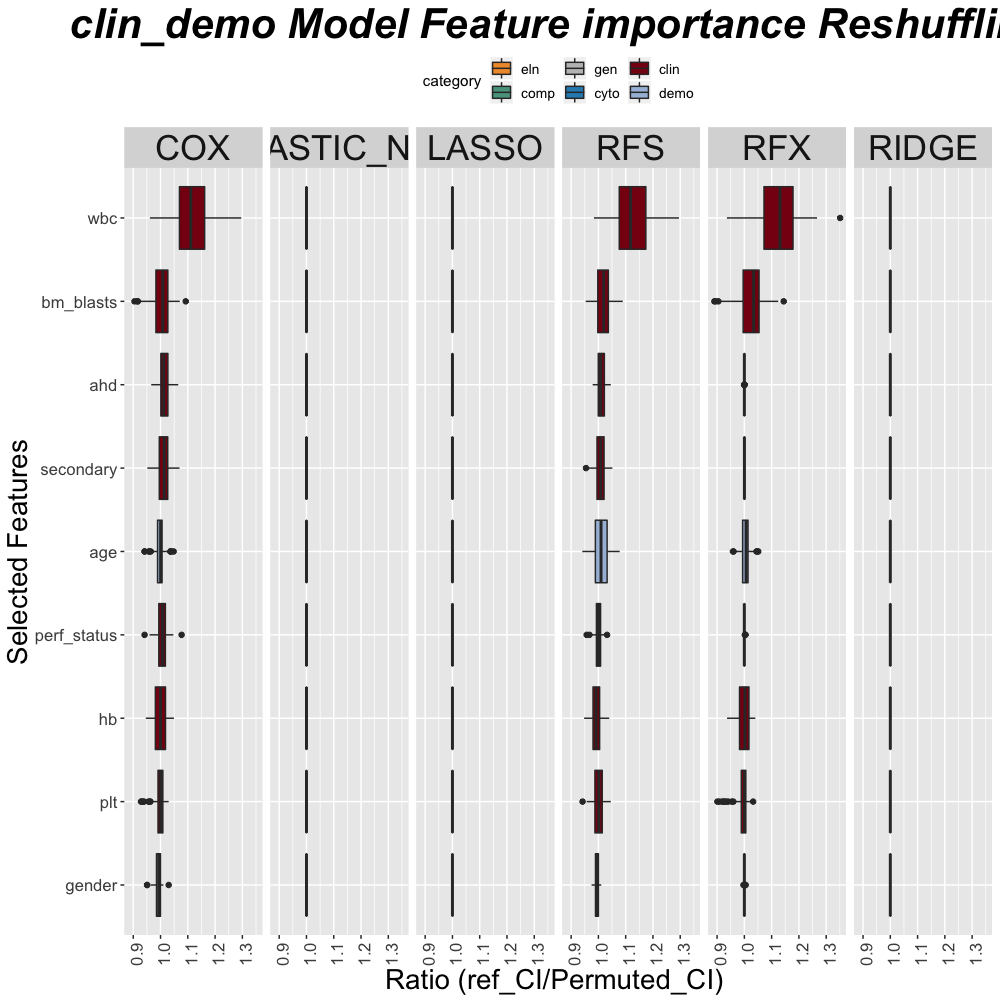

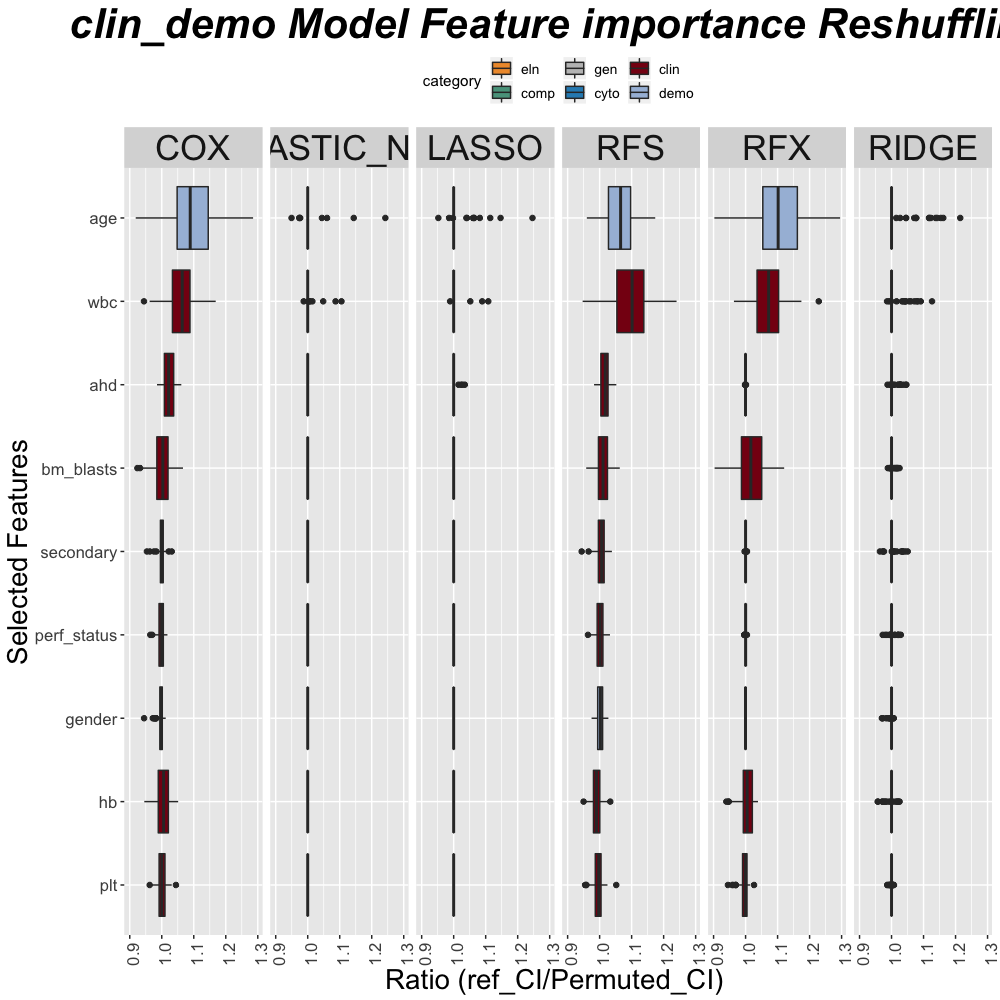

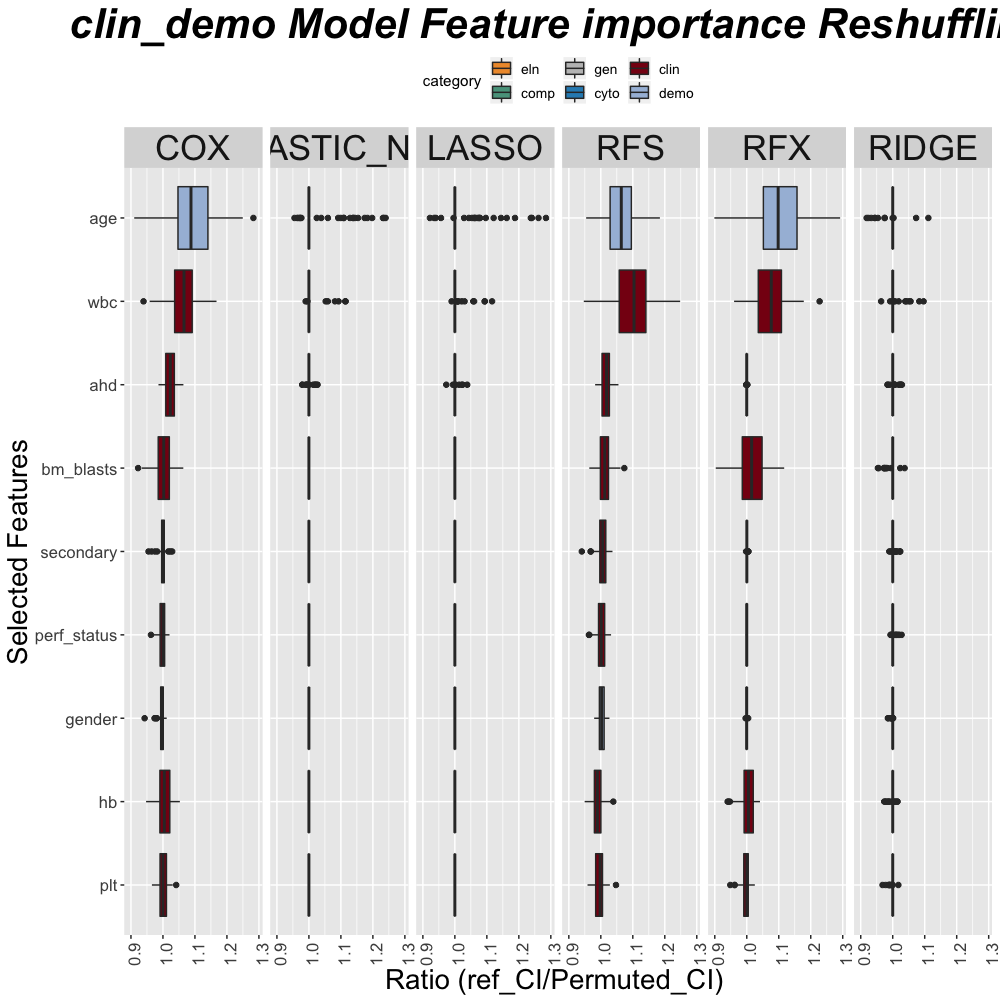

In [59]:
set_notebook_plot_size(10,10)
importance(data=df_reshuffling_RFS,models="clin_demo")
importance(data=df_reshuffling_OS_CR,models="clin_demo")
importance(data=df_reshuffling_os,models="clin_demo")

# All models

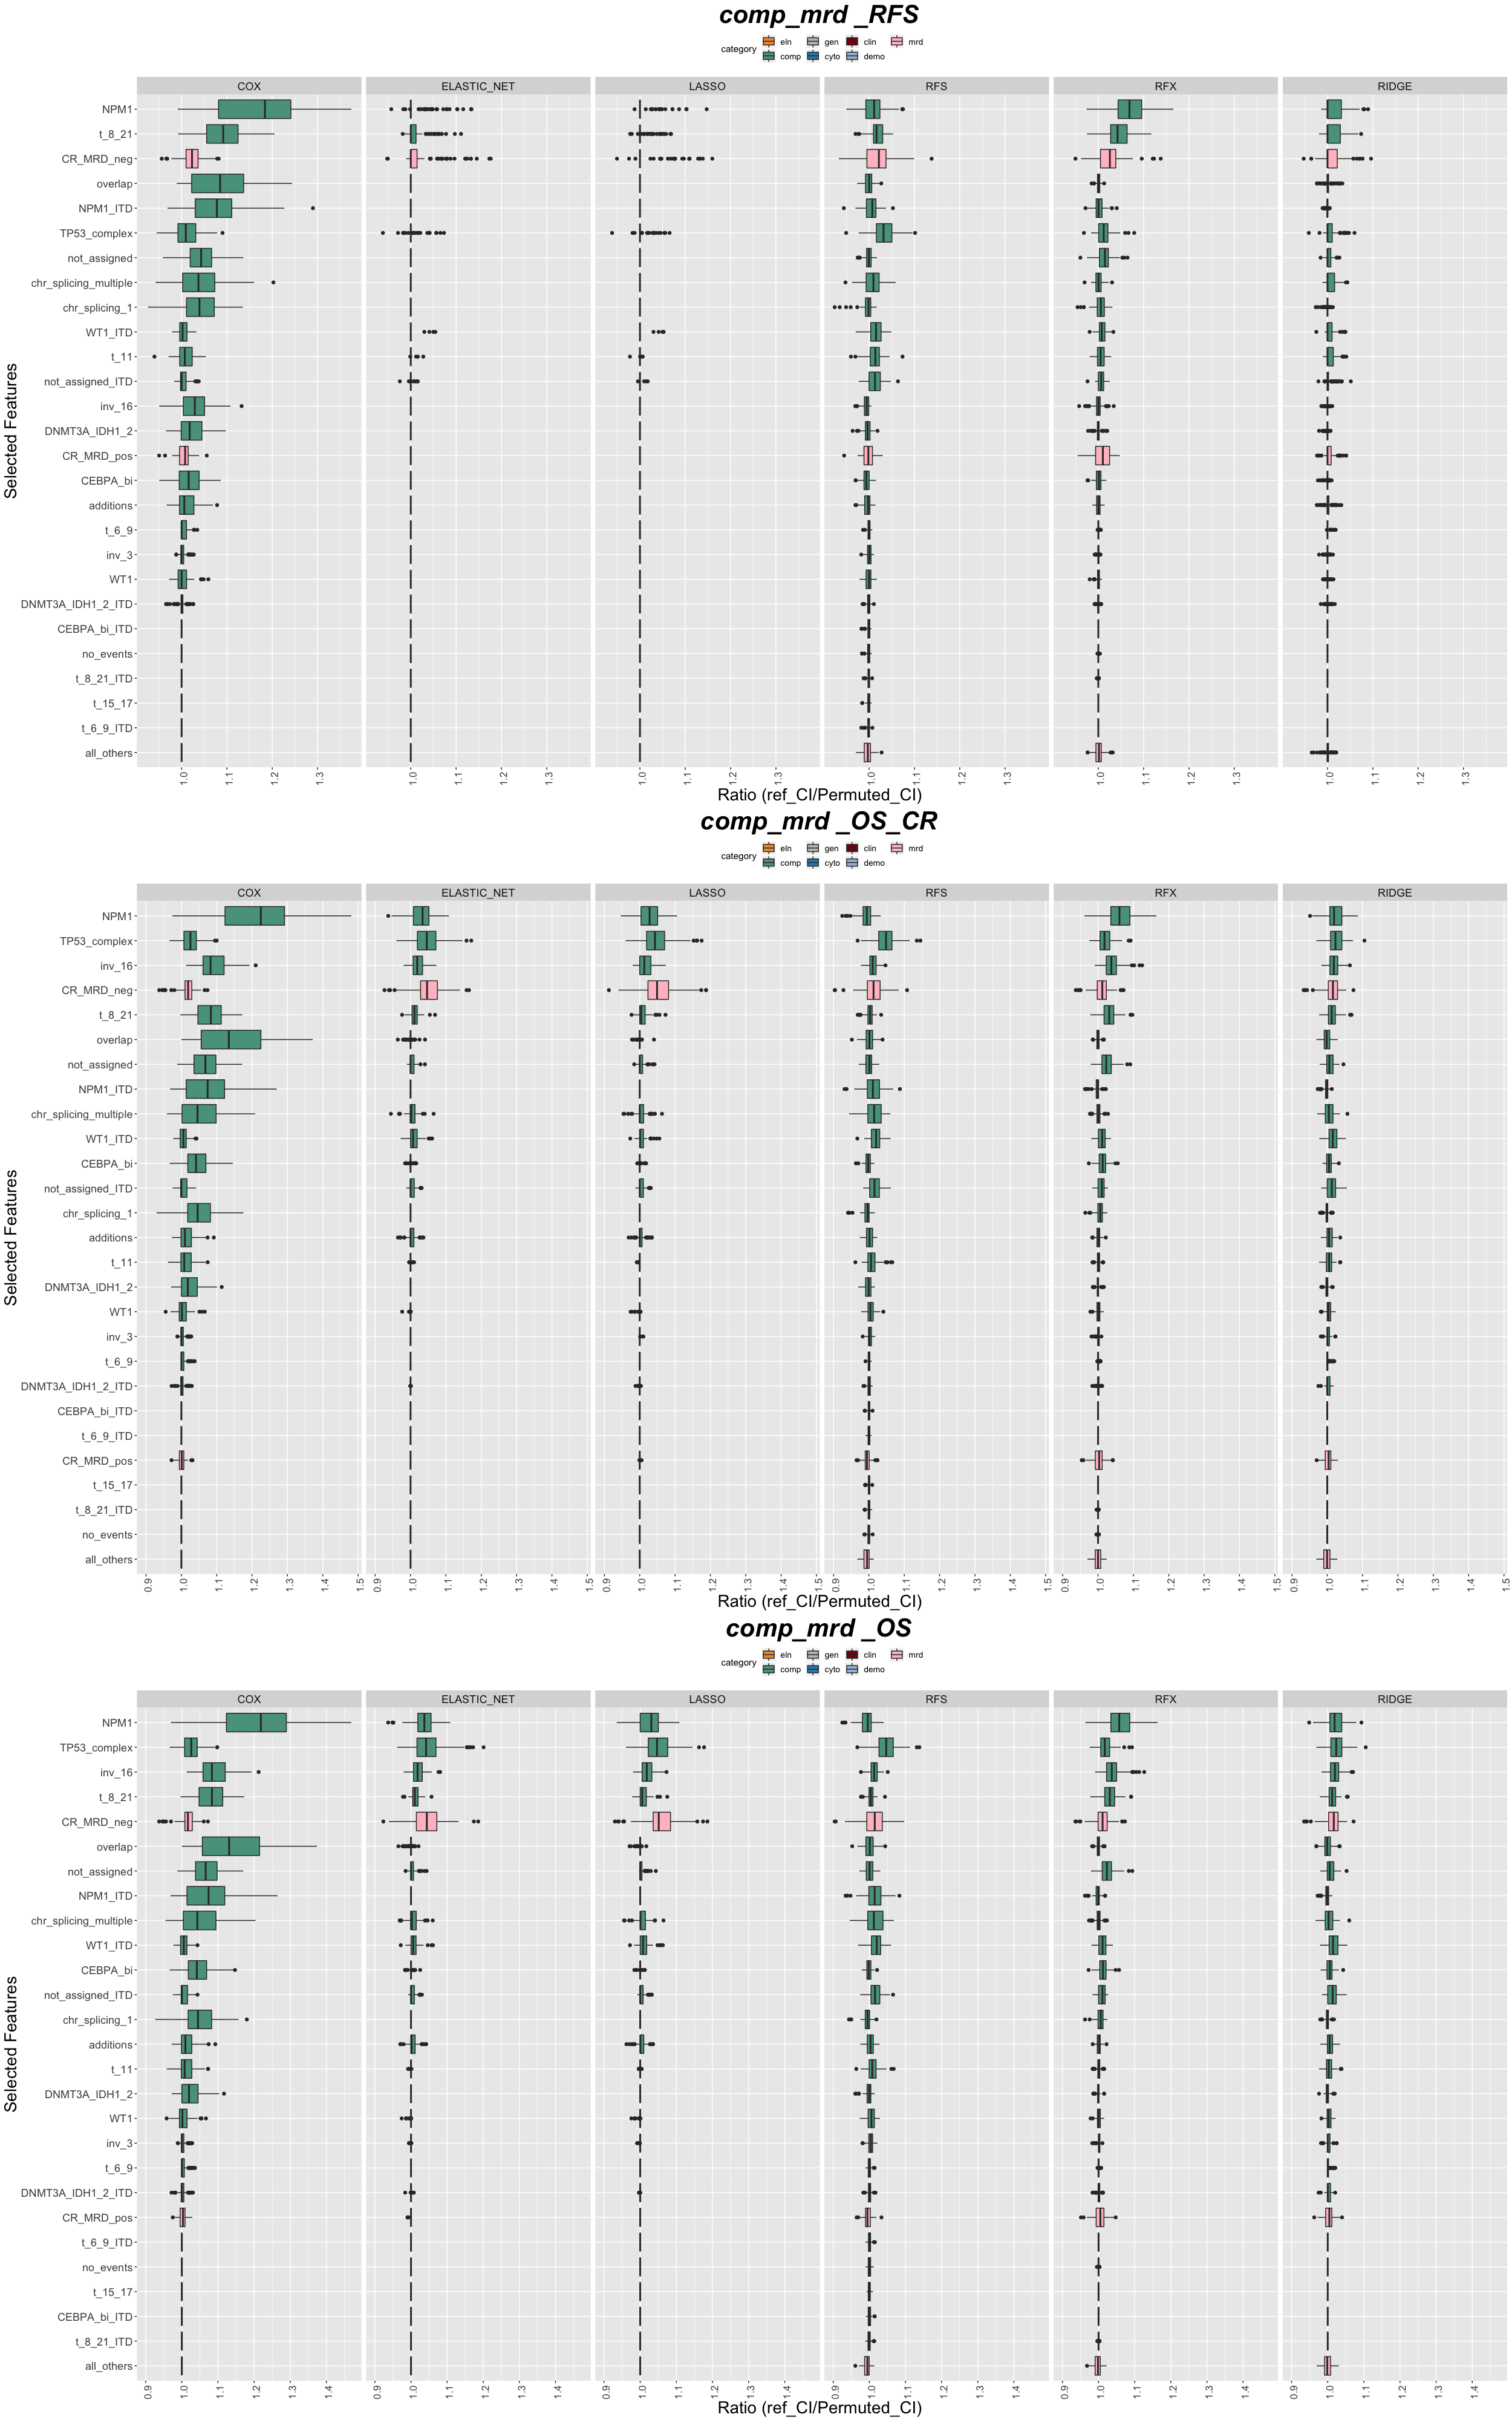

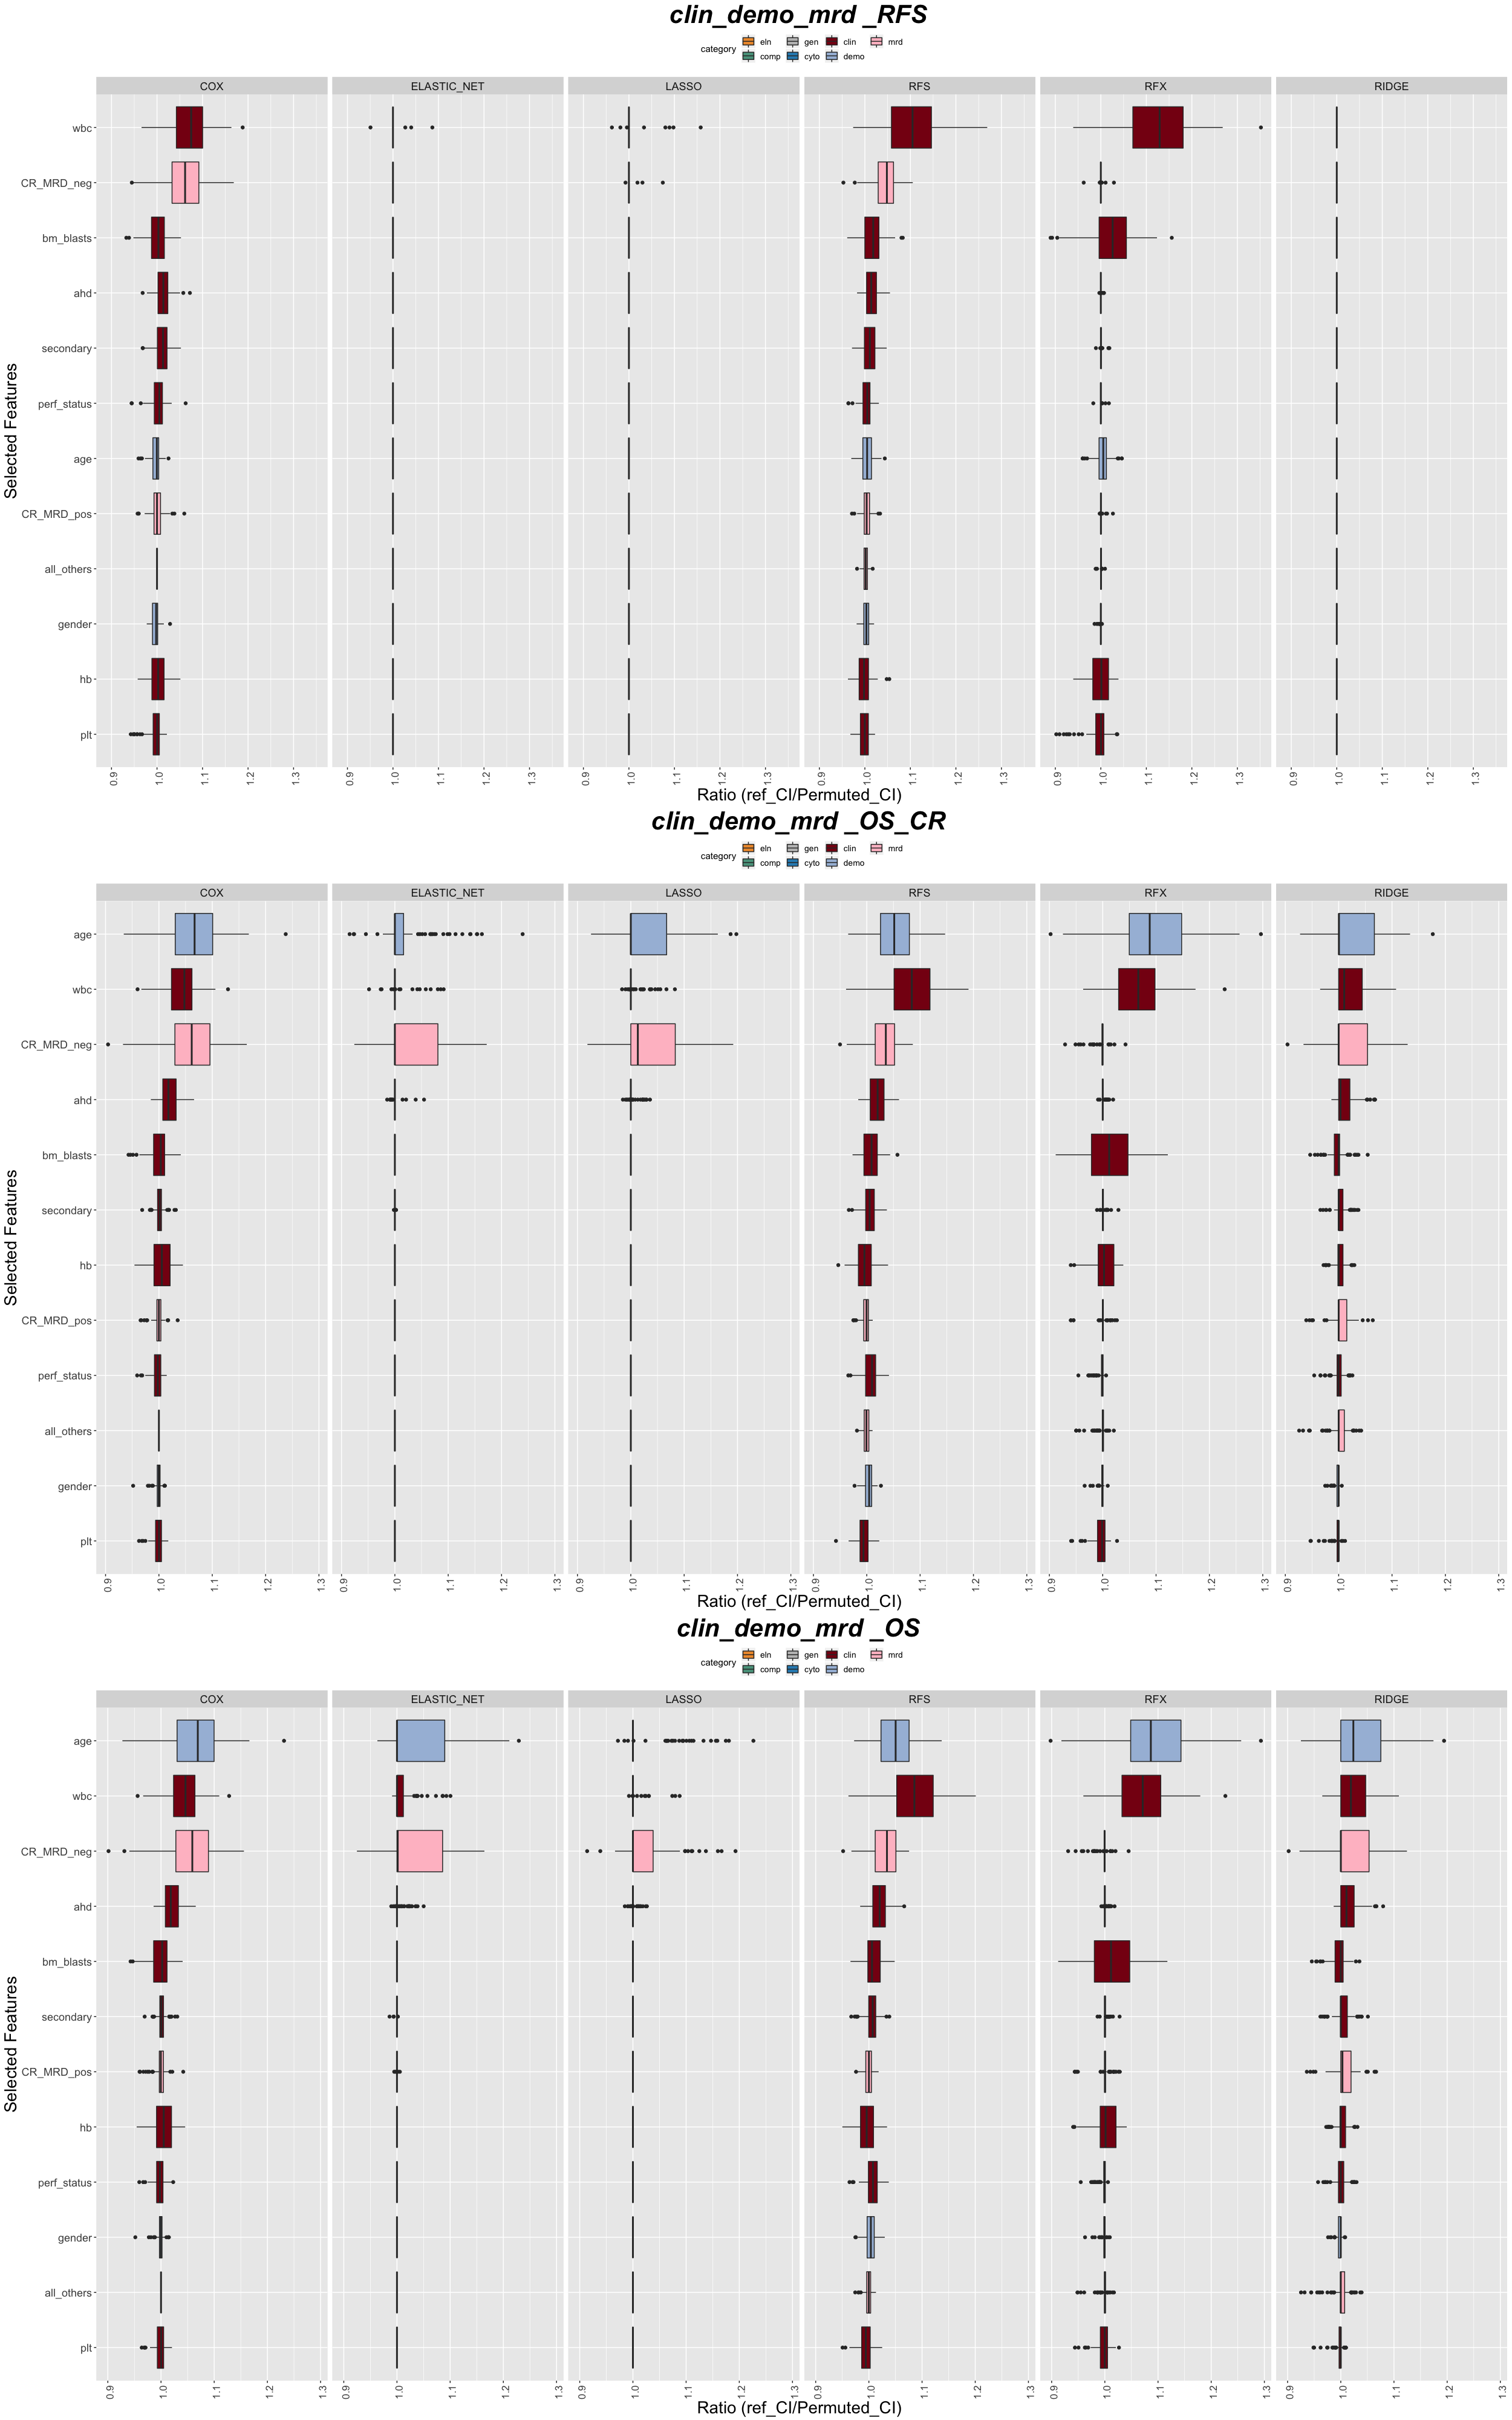

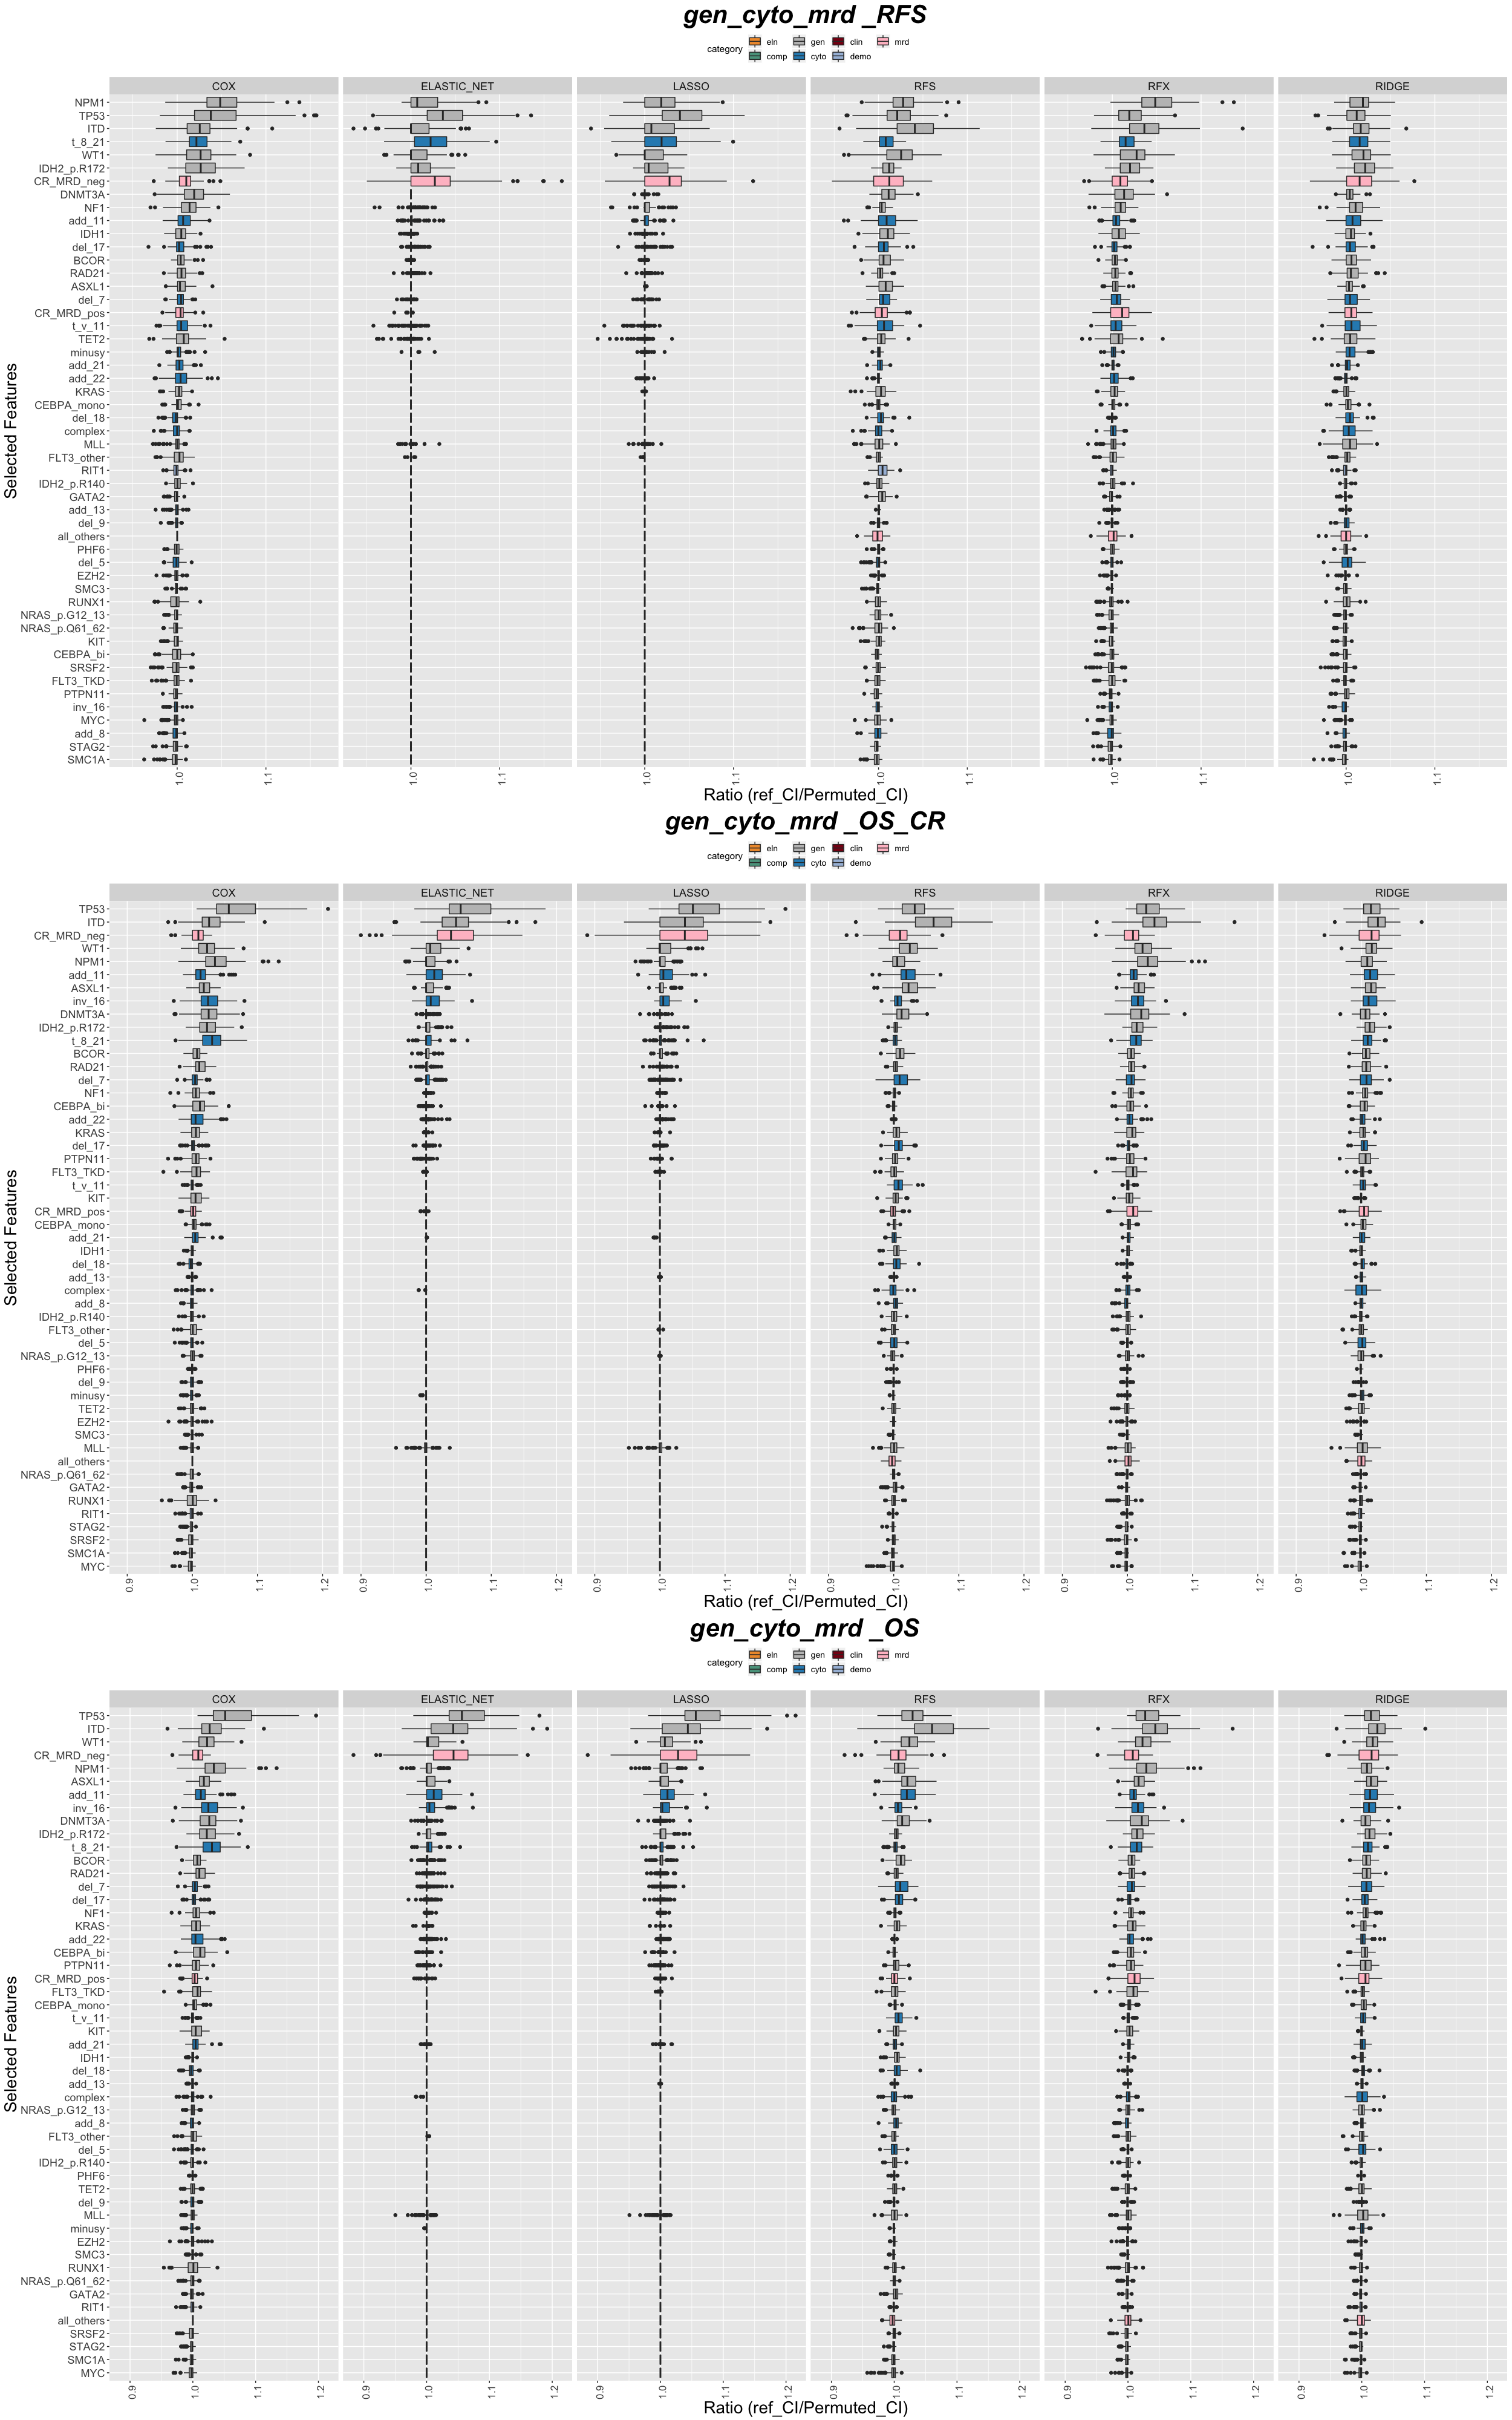

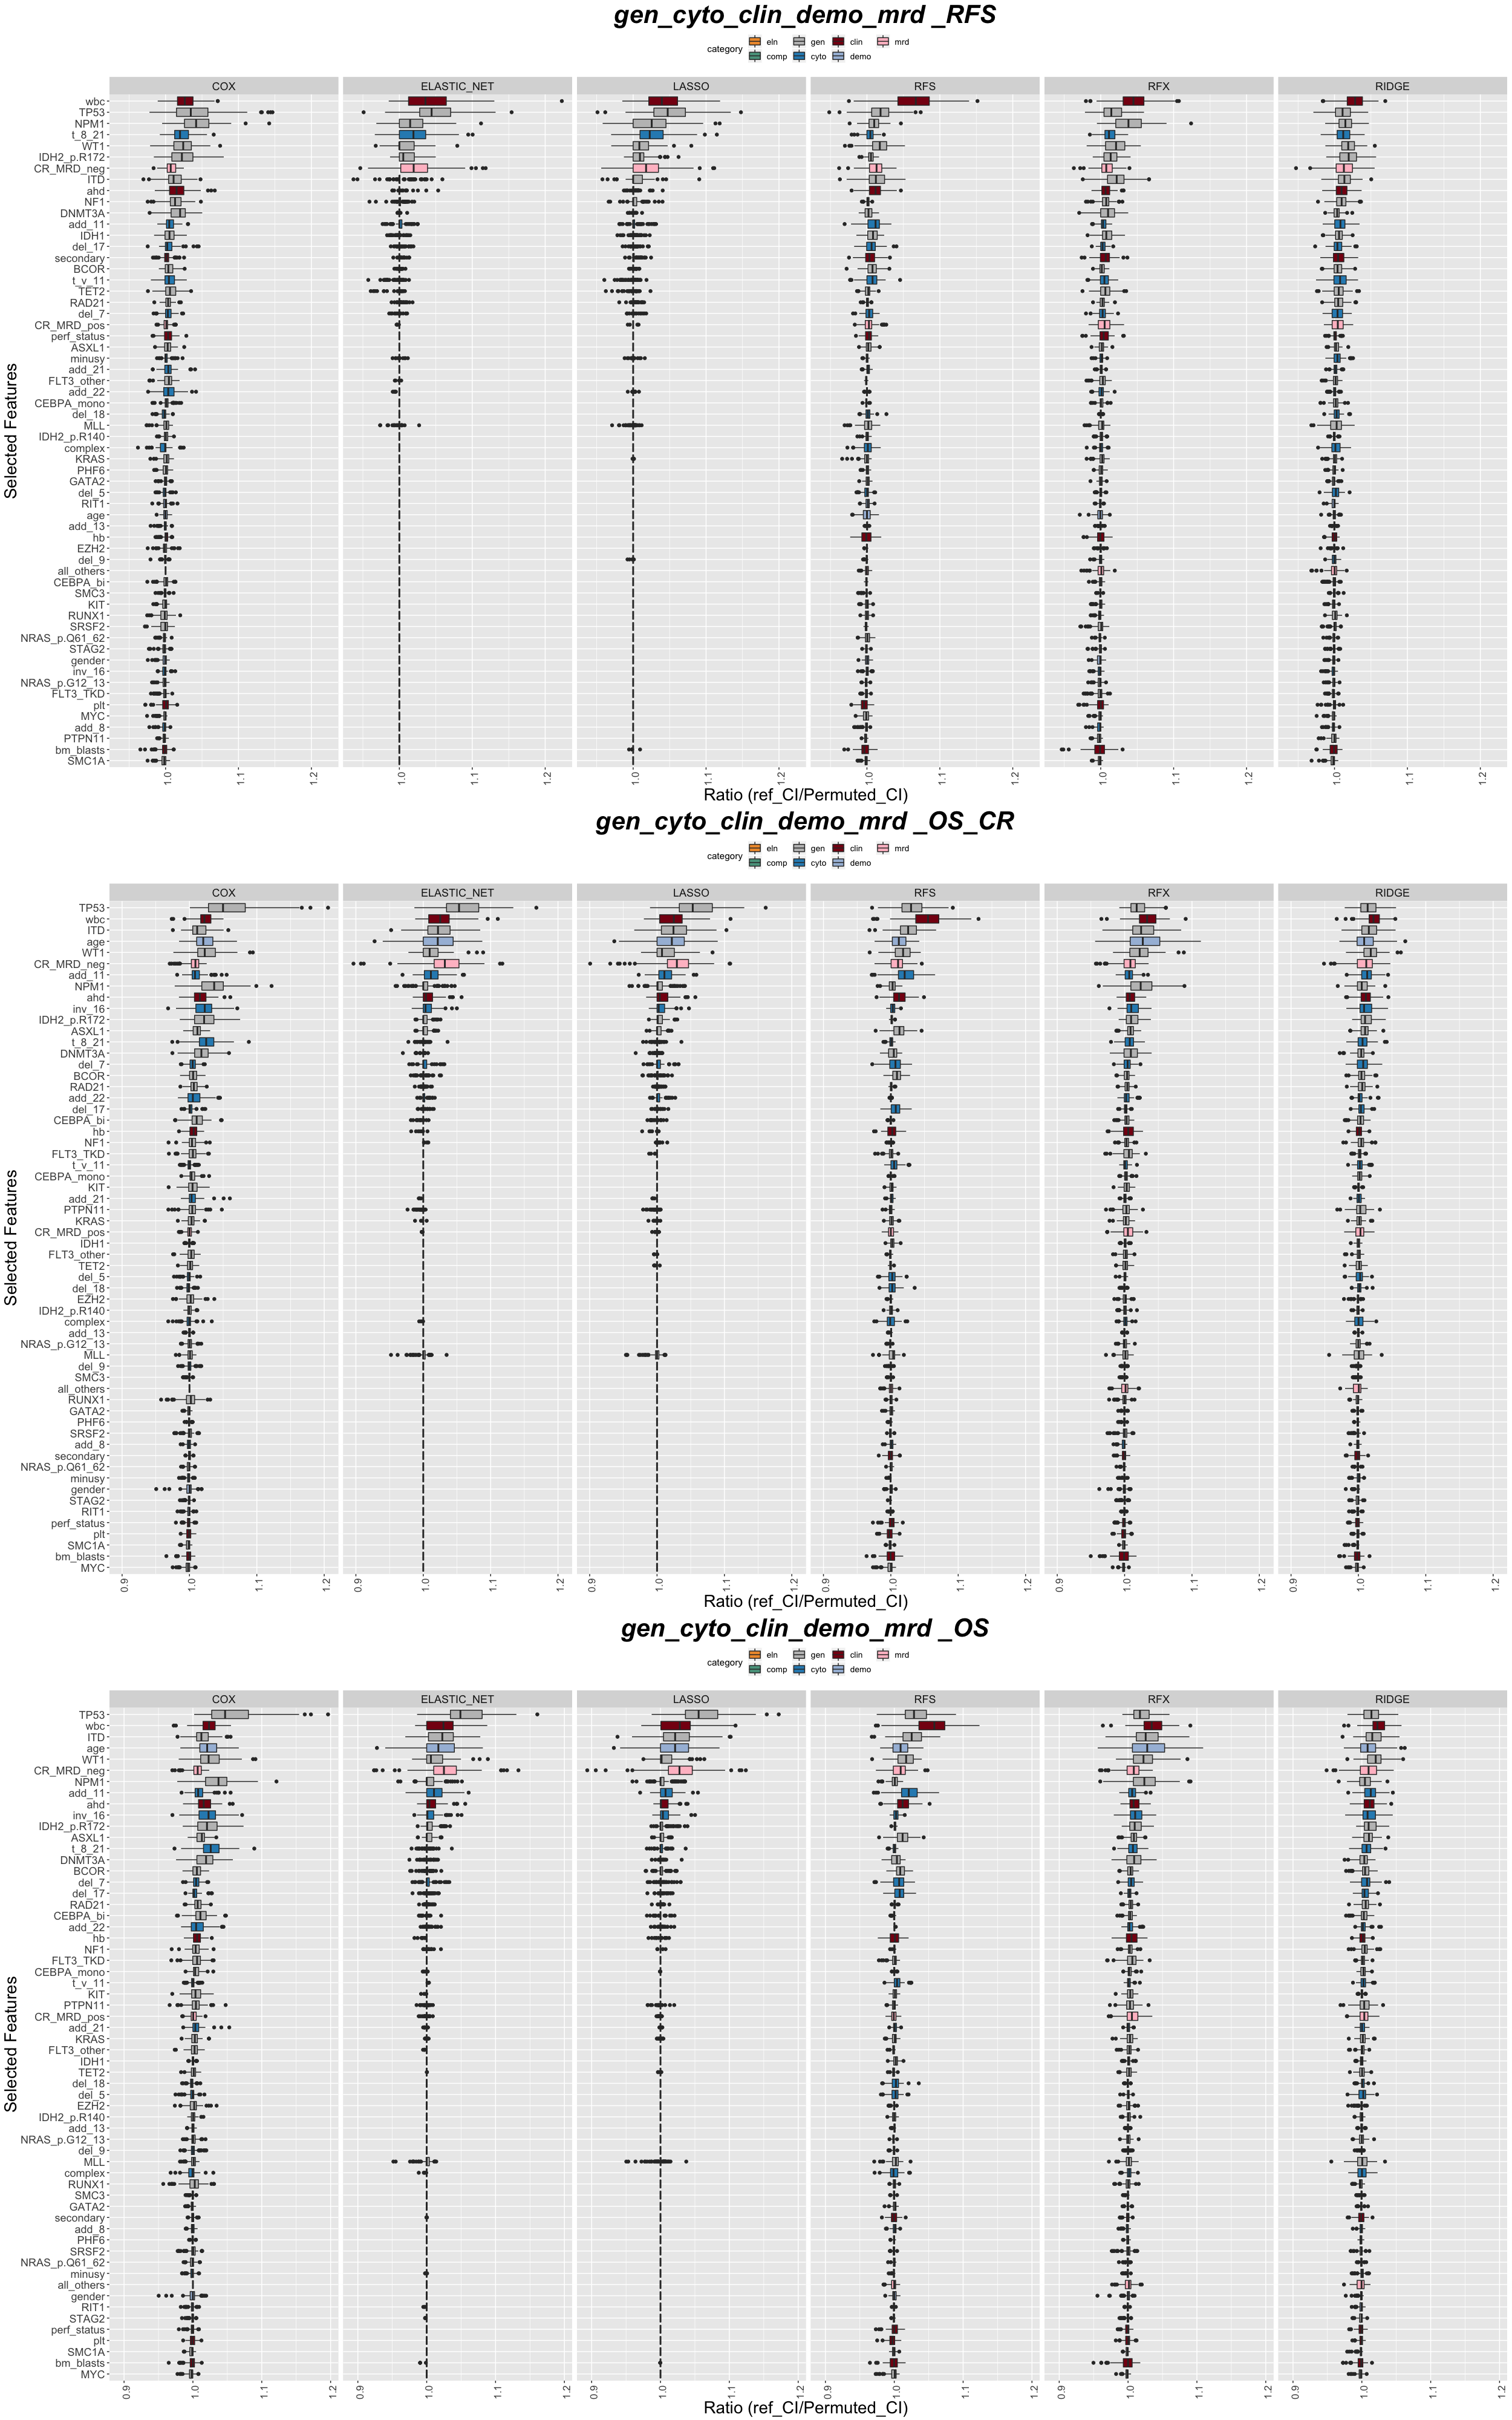

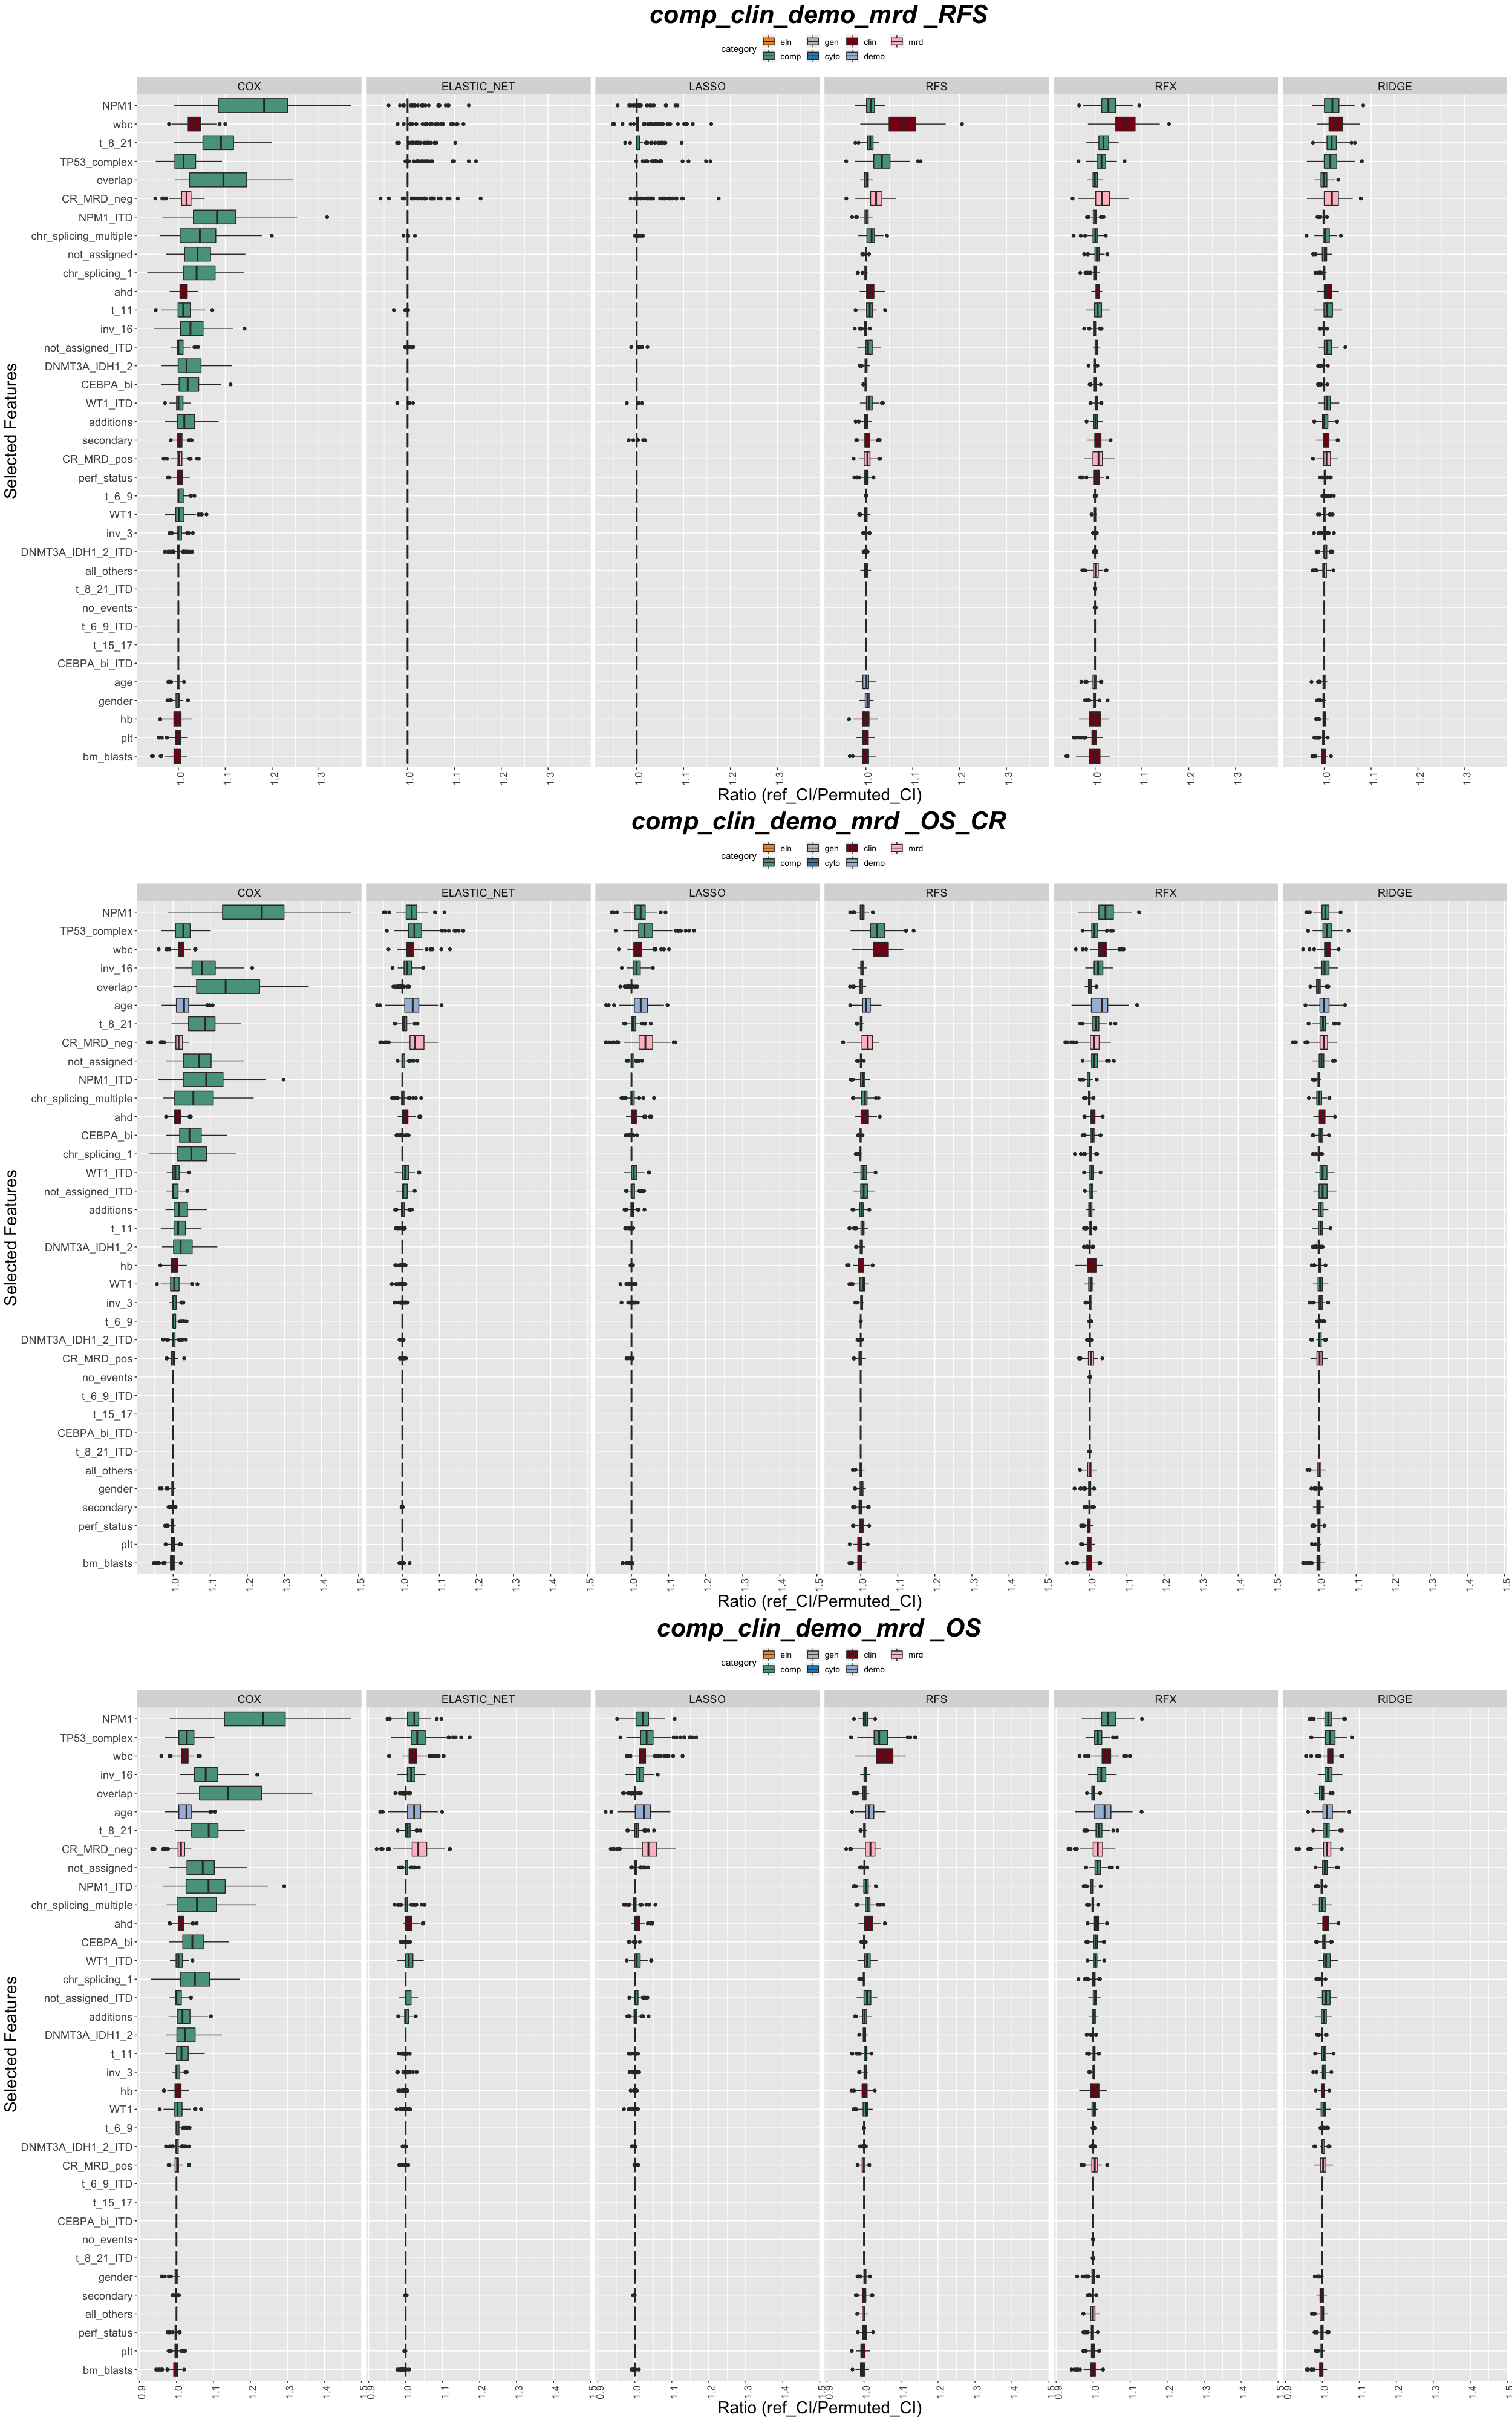

In [41]:
set_notebook_plot_size(25,40)
for (co in c("comp_mrd","clin_demo_mrd","gen_cyto_mrd","gen_cyto_clin_demo_mrd","comp_clin_demo_mrd")){
    grid.arrange(importance(data=df_reshuffling_RFS,models=co,title=paste(co,"_RFS","")),importance(data=df_reshuffling_OS_CR,models=co,title=paste(co,"_OS_CR","")),importance(data=df_reshuffling_os,models=co,title=paste(co,"_OS","")),nrow=3)
    }